# RESOLUCIÓN DE LA CONFIGURACIÓN ESTÁTICA

In [2]:
import math
import numpy as np
import random
import scipy
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import fsolve
from scipy.sparse import diags


## CONDICIONES INICIALES

Nsitios: cantidad de sitios
J: constante de acoplamiento de Heisenberg
K: constante de anisotropía
a: parámetro de red
Jsd: constante de acoplamiento s-d
t: integral de hopping
S0: valor de lmódulo del vector spin para todos los sitios

Los espines se escriben en un vector de $4*N_{sitios}$ componentes, donde las $3*N_{sitios}$ primeras componentes son las componentes x,y,z de los $N_{sitios} $ espines, mientras que las componentes restantes son restricciones a la norma del spin.


In [38]:
Nsitios = 100
n_occ = int(Nsitios) 
J=1      
K=1      
a=1      
Jsd=0.05
t=1       

S0 = 1   
    
S=np.zeros(4*Nsitios)     
Sxy = [complex(i, i) for i in range(Nsitios) ] 
e = int((S0)*(np.sqrt(J/K))) 
n0 = int(Nsitios/5)
n1 = int(3*Nsitios/4)

n= np.zeros(Nsitios)
for i in range(Nsitios):
    n[i]=i

S doble kink aplanado: 
 (400,)


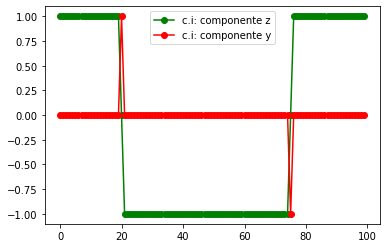

In [39]:
# ESTABLECER CONDICION INICIAL 
def doblekink(S):
    for n in range(0,n0 - e):
        S[3*n+0]=0
        S[3*n+1]=0
        S[3*n+2]=S0
    for n in range(n0-e,n0 +e):
        S[3*n+0]=0
        S[3*n+2]=-(S0/e)*(n-n0)
        
    for n in range(n0-e,n0):
        S[3*n+1]=(S0/e)*(n-n0) + S0
    for n in range(n0,n0+e):
        S[3*n+1]=-(S0/e)*(n-n0) + S0
              
    for n in range(n0+e,n1-e):
        S[3*n+0]=0
        S[3*n+1]=0
        S[3*n+2]=-S0
        
    for n in range(n1-e,n1+e):
        S[3*n+0]=0
        S[3*n+2]=(S0/e)*(n-n1) 
    
    for n in range(n1-e,n1):
        S[3*n+1]=-(S0/e)*(n-n1)-S0
    for n in range(n1,n1+e):
        S[3*n+1]=(S0/e)*(n-n1)-S0
    
    for n in range(n1+e,Nsitios):
        S[3*n+0]=0
        S[3*n+1]=0
        S[3*n+2]=S0
    for n in range(Nsitios):
        Sxy[n] = complex(S[3*n+0],S[3*n+1])
    return S



doblekink(S)
print("S doble kink aplanado: \n",S.shape)

# SOLUCION HOMOGÉNEA (ferromagnética)

def sol_hom(S):
    for n in range (Nsitios):
        S[3*n+0]=0
        S[3*n+1]=0
        S[3*n+2]=S0
        S[3*Nsitios+n]=0
        Sxy[n] = complex(S[3*n+0],S[3*n+1])
    return
# sol_hom(S)
# print(S.shape)


S = doblekink(S)
x = np.zeros(Nsitios)
y = np.zeros(Nsitios)
z = np.zeros(Nsitios)

for i in range(Nsitios):
    x[i]=S[3*i+0]
    y[i]=S[3*i+1]
    z[i]=S[3*i+2]

plt.plot(n,z, 'o-g',label='c.i: componente z')
plt.plot(n,y, 'o-r',label='c.i: componente y')

plt.legend()

## HAMILTONIANO

In [40]:
doblekink(S)

#Definir una matriz 2N*2N con unos (o ceros) para armar el hamiltoniano 
hamiltoniano = np.zeros((2*Nsitios,2*Nsitios), dtype=complex) #Se define de 0 a 2*Nsitios-1
diagonal = np.zeros((2*Nsitios,2*Nsitios), dtype=complex)


def Hamiltoniano(S):
    #Completar el hamiltoniano con los valores correspondientes a la matriz triangular superior
    for n in range(Nsitios-1):
    #hamiltoniano Hsd 
        hamiltoniano[2*n,2*n] = (Jsd/2) * S[3*n+2]
        hamiltoniano[2*n,2*n+1] = (Jsd/2) * (Sxy[n])
        hamiltoniano[2*n+1,2*n+1] = -(Jsd/2) * S[3*(n+1)+2]
    #hamiltoniano de hopping
        hamiltoniano[2*n,2*n+2] = -t
        hamiltoniano[2*n+1,2*n+3] = -t
    #matriz con valores del H en la diagonal
        diagonal[2*n,2*n] = (Jsd/2) * S[3*n+2]
        diagonal[2*n+1,2*n+1] = -(Jsd/2) * S[3*(n+1)+2]

    #Condiciones periódicas de contorno    
    hamiltoniano[2*Nsitios-2, 2*Nsitios-2] = (Jsd/2) * S[3*(Nsitios-1)+2]
    hamiltoniano[2*Nsitios-2, 2*Nsitios-1] = (Jsd/2) * (Sxy[Nsitios-1])
    hamiltoniano[2*Nsitios-1, 2*Nsitios-1] = -(Jsd/2) * S[3*(Nsitios-1)+2]
    hamiltoniano[0,2*Nsitios-2] = -t
    hamiltoniano[1,2*Nsitios-1] = -t
    #matriz con valores del H en la diagonal
    diagonal[2*Nsitios-2, 2*Nsitios-2] = (Jsd/2) * S[3*(Nsitios-1)+2]
    diagonal[2*Nsitios-1, 2*Nsitios-1] = -(Jsd/2) * S[3*(Nsitios-1)+2]
    #para terminar de armar el hamiltoniano traspongo la matriz y le elimino los valores de la diagonal para
    #que no se dupliquen, entonces ahí sumo ambas matrices
    h_final = hamiltoniano + np.conj(hamiltoniano.transpose()) - diagonal
    
    autovalores,autovectores = np.linalg.eig(h_final)
    idx = autovalores.argsort()[::1] 

    # Los autovectores están dados como vectores columna de la matriz (de autovectores). El i-ésimo autovector 
    # se encuentra con v[:,i]
    autovalores = autovalores[idx]
    autovectores = autovectores[:,idx]
    return autovectores

autovectores = Hamiltoniano(doblekink(S))
# print(autovectores)

# print("HAMILTONIANO: \n")
# print(h_final, "\n")
# print("autovalores: ", autovalores, "\n")
# for i in range(2*Nsitios):
#     print("autovectores[",i,"]", autovectores[:,i])

    
    

### ORTONORMALIDAD DE LOS AUTOVECTORES

In [41]:
# for i in range(2*Nsitios):
#     print(np.sqrt(np.vdot(autovectores[:,i],autovectores[:,i])))


## ECUACIONES DE SPIN

#### TÉRMINO ELECTRÓNICO

Armamos el término electrónico del hamiltoniano utilizando el método vdot de numpy, que se encarga de realizar el producto
de dos números complejos, pero conjugando al primero de los mismos como paso previo. Realizamos el cálculo para los autovectores de la matriz obtenida previamente, tomando la j-ésima fila (es decir la j-ésima componente de cada vector, que representa el spin up del sitio j) y haciendo el producto con la (j+1)-ésima fila  (que representa el spin down del sitio j).

Para ordenar los valores y que no se preste a confusión, creamos la matriz <b>sumas</b>, donde las filas representan las ecuaciones (9, 10 y 11 en las notas) y las columnas el término de la sumatoria (cada ecuación tiene dos sumatorias, entonces tengo columna 0 para el primer término y columna 1 para el segundo).

El número n_occ (cantidad de electrones del sistema, llenado de la banda) ingresado en la primer celda de este notebook, es independiente de la cantidad de sitios (i.e de la cantidad de espines). Por ejemplo, puedo tener la cadena electrónica totalmente vacía o totalmente llena.  Por lo tanto, el rango de valores que puede tomar n_occ varía desde 0 hasta 2*N_sitios.

Spin total de la cadena de electrones y spin total de la cadena de espines no son buenos números cuánticos por separado. Si consideramos la suma de ambos sistemas, entonces sí el spin total es un buen numero cuántico (es una cantidad conservada). 

In [42]:
# A=np.array(([1,3,3,4,5],[2,2,4,5,6]))
# print(A)
# print(A[0,1:4])
# print(A[1,1:4])
# print(np.vdot(A[0,1:4],A[0,1:4])-np.vdot(A[1,1:4],A[1,1:4]))


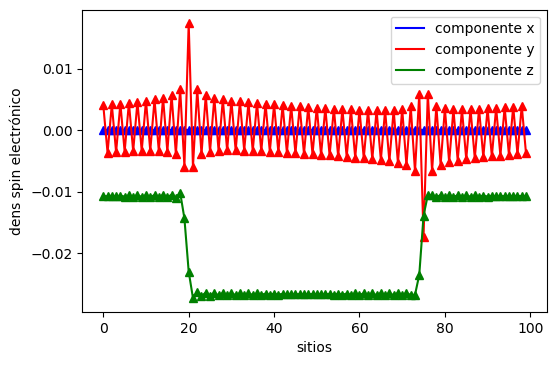

In [43]:
#n_occ no puede estar completamente desvinculado de Nsitios, el maximo es 2Nsitios. Lleno la mitad de la cadena:  
s_el = np.zeros((Nsitios,3))
    
def densidadelectronica(autovectores,n_occ):
    for i in range(Nsitios):
        s_el[i,0] = 2*np.real(np.vdot(autovectores[2*i+0,0:n_occ],autovectores[2*i+1,0:n_occ]))
        s_el[i,1] = 2*np.imag(np.vdot(autovectores[2*i+0,0:n_occ],autovectores[2*i+1,0:n_occ]))
        s_el[i,2] = -np.real(np.vdot(autovectores[2*i+0,0:n_occ],autovectores[2*i+0,0:n_occ])-np.vdot(autovectores[2*i+1,0:n_occ],autovectores[2*i+1,0:n_occ]))
    return s_el

s_el = densidadelectronica(autovectores,n_occ)

n= np.zeros(Nsitios)
for i in range(Nsitios):
    n[i]=i
    y1= np.zeros(Nsitios)
    y2= np.zeros(Nsitios)
    y3= np.zeros(Nsitios)
for i in range(Nsitios):
    n[i]=i 
    y1[i]=s_el[i,0]
    y2[i]=s_el[i,1]
    y3[i]=s_el[i,2]    
    
plt.figure(dpi=100)
plt.plot(n,y1,'b^')
plt.plot(n,y1, 'b',label="componente x" )
plt.plot(n,y2,'r^')
plt.plot(n,y2, 'r',label="componente y")
plt.plot(n,y3,'g^')
plt.plot(n,y3, 'g',label="componente z")
plt.xlabel('sitios')
plt.ylabel('dens spin electrónico')
plt.legend()

# for j in range(8):
#     plt.figure(dpi=100)
#     plt.plot(n,np.square(abs(autovectores[::2,j])),'r')
#     plt.plot(n,np.square(abs(autovectores[1::2,j])),'b')
#     plt.xlabel('sitios',fontsize=15)
#     plt.ylabel('$|\psi|^2$',fontsize=15)
#     plt.title('autovector %s' %j)

# plt.figure(dpi=100)
# plt.plot(n,np.square(abs(autovectores[::2,Nsitios+2])),'r')
# plt.plot(n,np.square(abs(autovectores[1::2,Nsitios+2])),'b')
# plt.xlabel('sitios',fontsize=15)
# plt.ylabel('$|\psi|^2$',fontsize=15)
# plt.title('autovector Nsitios+2')
    
# plt.savefig('dens_espin_electronico.png',dpi=300)




#### ECUACIONES DE SPIN

En las notas aparecen como ecuaciones 9, 10 y 11. Las ecuaciones se armaron siguiendo lo escrito en la sección "resolución del programa en python"

In [44]:

def Ecuaciones(S,s_el):
    f = np.zeros(4*Nsitios)
   
    #condiciones de contorno periodicas
    #construyendo la funcion como un vector entero, solo:

#     f[0] = (-J* (S[3*(Nsitios-1)+1]+S[3*(0+1)+1])+(Jsd/2)*(s_el[0,1])) *S[2]  -  (-J*(S[3*(Nsitios-1)+2]+S[5]) - 2*K*S[2] + (Jsd/2)*(s_el[0,2])) * S[1]
#     f[1] = -(-J* (S[3*(Nsitios-1)+0]+S[3*(0+1)+0])+(Jsd/2)*(s_el[0,0])) *S[2]  +  (-J*(S[3*(Nsitios-1)+2]+S[5]) - 2*K*S[2] + (Jsd/2)*(s_el[0,2])) * S[0]
#     f[2] = (-J* (S[3*(Nsitios-1)+0]+S[3*(0+1)+0])+(Jsd/2)*(s_el[0,0])) *S[1]  -  (-J*(S[3*(Nsitios-1)+1]+S[4]) - 2*K*S[2] + (Jsd/2)*(s_el[0,1])) * S[0]
#     f[3*(Nsitios-1)+0] = (-J* (S[3*(Nsitios-2)+1]+S[1])+(Jsd/2)*(s_el[Nsitios-1,1])) * S[3*(Nsitios-1)+2]  -  (-J*(S[3*(Nsitios-2)+2]+S[2])  - (2*K*S[3*(Nsitios-1)+2] + (Jsd/2)*(s_el[Nsitios-1,2]))) * S[3*(Nsitios-1+1)]
#     f[3*(Nsitios-1)+1] = -(-J* (S[3*(Nsitios-2)+0]+S[0])+(Jsd/2)*(s_el[Nsitios-1,0])) * S[3*(Nsitios-1)+2]  +  (-J*(S[3*(Nsitios-2)+2]+S[2])  - (2*K*S[3*(Nsitios-1)+2] + (Jsd/2)*(s_el[Nsitios-1,1]))) * S[3*(Nsitios-1+0)]
#     f[3*(Nsitios-1)+2] = (-J* (S[3*(Nsitios-2)+0]+S[0])+(Jsd/2)*(s_el[Nsitios-1,0])) * S[3*(Nsitios-1)+1]  -  (-J*(S[3*(Nsitios-2)+1]+S[1])  - (2*K*S[3*(Nsitios-1)+2] - (Jsd/2)*(s_el[Nsitios-1,1]))) * S[3*(Nsitios-1+0)]
#  
    f[0] = (-J*(S[3*(Nsitios-1)+1]+S[3*(0+1)+1])+(Jsd/2)*(s_el[0,1])) * S[2]  -  (-J*(S[(Nsitios-1)*3+2] + S[(0+1)*3+2])- 2*K*S[2] + (Jsd/2)*(s_el[0,2])) * S[1]  
    f[1] = -(-J*(S[3*(Nsitios-1)+0]+S[3*(0+1)+0])+(Jsd/2)*(s_el[0,0])) * S[2]  +  (-J*(S[(Nsitios-1)*3+2] + S[(0+1)*3+2])- 2*K*S[2] + (Jsd/2)*(s_el[0,2])) * S[0]
    f[2] = (-J*(S[3*(Nsitios-1)+0]+S[3*(0+1)+0])+(Jsd/2)*(s_el[0,0])) * S[1]  -  (-J*(S[(Nsitios-1)*3+1] + S[(0+1)*3+1]) + (Jsd/2)*(s_el[0,1])) * S[0]
    f[3*(Nsitios-1)+0] = (-J*(S[3*(Nsitios-2)+1]+S[1])+(Jsd/2)*(s_el[Nsitios-1,1])) * S[(Nsitios-1)*3+2]  -  (-J*(S[(Nsitios-2)*3+2] + S[2])- 2*K*S[(Nsitios-1)*3+2] + (Jsd/2)*(s_el[Nsitios-1,2])) * S[3*(Nsitios-1)+1]  
    f[3*(Nsitios-1)+1] = -(-J*(S[3*(Nsitios-2)+0]+S[0])+(Jsd/2)*(s_el[Nsitios-1,0])) * S[(Nsitios-1)*3+2]  +  (-J*(S[(Nsitios-2)*3+2] + S[2])- 2*K*S[(Nsitios-1)*3+2] + (Jsd/2)*(s_el[Nsitios-1,2])) * S[3*(Nsitios-1)+0]
    f[3*(Nsitios-1)+2] = (-J*(S[3*(Nsitios-2)+0]+S[0])+(Jsd/2)*(s_el[Nsitios-1,0])) * S[(Nsitios-1)*3+1]  -  (-J*(S[(Nsitios-2)*3+1] + S[1]) + (Jsd/2)*(s_el[Nsitios-1,1])) * S[3*(Nsitios-1)+0]

#bulk de la cadena
    for i in range(1,Nsitios-1):
        #AML. Corrijo signo
        f[3*i+0] = (-J*(S[3*(i-1)+1]+S[3*(i+1)+1])+(Jsd/2)*(s_el[i,1])) * S[i*3+2]  -  (-J*(S[(i-1)*3+2] + S[(i+1)*3+2])- 2*K*S[i*3+2] + (Jsd/2)*(s_el[i,2])) * S[3*i+1]  
        f[3*i+1] = -(-J*(S[3*(i-1)+0]+S[3*(i+1)+0])+(Jsd/2)*(s_el[i,0])) * S[i*3+2]  +  (-J*(S[(i-1)*3+2] + S[(i+1)*3+2])- 2*K*S[i*3+2] + (Jsd/2)*(s_el[i,2])) * S[3*i+0]
        #Corrijo las componentes z y el signo de s_el[j,y]
        #        f[3*i+2] = (-J*(S[3*(i-1)+0]+S[3*(i+1)+0])+(Jsd/2)*(s_el[i,0])) * S[i*3+1]  -  (-J*(S[(i-1)*3+1] + S[(i+1)*3+1])- 2*K*S[i*3+2] - (Jsd/2)*(s_el[i,1])) * S[3*i+0]
        f[3*i+2] = (-J*(S[3*(i-1)+0]+S[3*(i+1)+0])+(Jsd/2)*(s_el[i,0])) * S[i*3+1]  -  (-J*(S[(i-1)*3+1] + S[(i+1)*3+1]) + (Jsd/2)*(s_el[i,1])) * S[3*i+0]

    #constraints sobre el módulo de los espines
    for i in range(0,Nsitios):
        f[3*Nsitios+i] = np.sqrt((S[3*i+0])**2 + (S[3*i+1])**2 + (S[3*i+2])**2) - S0
    return f

def energia(S):
    aux =0
    for i in range(0,Nsitios):
        aux += -J*((S[3*i+0]*S[3*(i+1)+0])+(S[3*i+1]*S[3*(i+1)+1])+(S[3*i+2]*S[3*(i+1)+2])) -K*((S[3*i+2])**2) + ((S[3*Nsitios+i])*((S[3*i+0])**2 + (S[3*i+1])**2 + (S[3*i+2])**2 - S0**2))**2
    aux += -J*((S[3*(Nsitios-1)+0]*S[3*(0)+0])+(S[3*(Nsitios-1)+1]*S[3*(0)+1])+(S[3*(Nsitios-1)+2]*S[3*(0)+2])) -K*((S[3*(Nsitios-1)+2])**2) +((S[3*Nsitios+(Nsitios-1)])*((S[3*(Nsitios-1)+0])**2 + (S[3*(Nsitios-1)+1])**2 + (S[3*(Nsitios-1)+2])**2 - S0**2))**2
    return aux

In [45]:
# sol_hom(S)
# print("ENERGÍA DE LA SOLUCION FERRO: ",energia(S))

# doblekink(S)
# print("ENERGÍA DE LA SOLUCION CON DOBLE KINK: ",energia(S))

#### BÚSQUEDA DE LAS SOLUCIONES A LAS ECUACIONES 9 10 y 10 MEDIANTE EL MÉTODO FSOLVE DE NUMPY

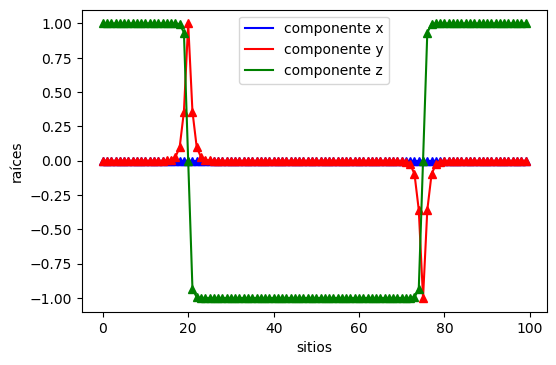

In [46]:
doblekink(S)
S = fsolve(Ecuaciones, S,s_el)

# print("\n Raíces: \n ",S)
# print(Ecuaciones(S))

# sol_hom(S)
# res = minimize(energia, S, method='SLSQP', tol=1e-6)
# print(res)

#Reescribir las raíces en forma matricial
matriz_raices = np.zeros((Nsitios,3))
for i in range(Nsitios):
    matriz_raices[i,0]=S[3*i+0]
    matriz_raices[i,1]=S[3*i+1]
    matriz_raices[i,2]=S[3*i+2]
# print("\n Las raíces, ordenadas en una matriz y sin los valores adicionales del vector S son: \n", matriz_raices)

#Armar vectores con los valores para poder graficar las raíces

n= np.zeros(Nsitios)
y1= np.zeros(Nsitios)
y2= np.zeros(Nsitios)
y3= np.zeros(Nsitios)
for i in range(Nsitios):
    n[i]=i 
    y1[i]=matriz_raices[i,0]
    y2[i]=matriz_raices[i,1]
    y3[i]=matriz_raices[i,2]
    
plt.figure(dpi=100)
plt.plot(n,y1,'b^')
plt.plot(n,y1, 'b',label="componente x" )
plt.plot(n,y2,'r^')
plt.plot(n,y2, 'r',label="componente y")
plt.plot(n,y3,'g^')
plt.plot(n,y3, 'g',label="componente z")
plt.xlabel('sitios')
plt.ylabel('raíces')
plt.legend()
plt.savefig('final plot1.png',dpi=300)

In [47]:
# doblekink(S)
# optimize.broyden1(Ecuaciones,doblekink(S))

In [48]:
tol =10e-5
k=0

#ingreso la condición inicial en el vector S
#S=S[0:3*Nsitios]
print(S)        

Saux = np.zeros(4*Nsitios)

aux=np.zeros(3*Nsitios)
#resta = np.zeros(4*Nsitios)

#for i in range (4*Nsitios):
#    resta[i] = S[i] - Saux[i]

error=np.linalg.norm(S-Saux)/Nsitios

#comp_extras=np.zeros(Nsitios)
while error>tol:
    if (k==0):
        print("S inicial")
    #    S = S[0:3*Nsitios]
    #    S = np.concatenate((S,comp_extras))

    #problema de aval/avec 
    
    autovectores = Hamiltoniano(S)
    
    #resolver ecuaciones
    s_elec = densidadelectronica(autovectores,n_occ)
    
    #encontrar raíces
    Saux= fsolve(Ecuaciones,S,s_elec)
    
    error=np.linalg.norm(S-Saux)

    for i in range(3*Nsitios):
        aux[i]= S[i]-Saux[i]
    print("Norma del vector de las primeras componentes", np.linalg.norm(aux)/Nsitios)
    for i in range(3*Nsitios):
        aux[i]=0
    
    
    S=Saux
    #aumentar un paso en la iteración
    k+=1
    print("k: ",k)
    print("error total:", error)
    #print(S)

print(k)
print("S final")
print(S)
print(S.shape)

[ 9.65723089e-16 -1.83461357e-05  1.00000000e+00  9.77926728e-16
  1.34344035e-05  1.00000000e+00  6.94978712e-16 -1.97990660e-05
  1.00000000e+00  1.04586849e-15  1.20994538e-05  1.00000000e+00
  9.36174890e-16 -2.12755712e-05  1.00000000e+00  5.96139670e-16
  1.08149150e-05  1.00000000e+00  1.02665548e-15 -2.27699075e-05
  1.00000000e+00  7.92119768e-16  9.63537311e-06  1.00000000e+00
  4.71320288e-16 -2.41450242e-05  1.00000000e+00  9.26517912e-16
  9.13961376e-06  1.00000000e+00  5.97116578e-16 -2.33540481e-05
  1.00000000e+00  2.94208910e-16  1.71009086e-05  1.00000000e+00
  6.05253366e-16  8.40517690e-06  1.00000000e+00 -2.54936352e-17
  1.41300017e-04  9.99999990e-01 -1.69819006e-15  4.72962935e-04
  9.99999888e-01 -6.09679506e-15  1.88217461e-03  9.99998229e-01
 -2.48233438e-14  6.96928812e-03  9.99975714e-01 -9.35023770e-14
  2.61369080e-02  9.99658373e-01 -3.48929673e-13  9.73813752e-02
  9.95247139e-01 -1.28397542e-12  3.57992734e-01  9.33724372e-01
 -3.58786574e-12  9.99999

Norma del vector de las primeras componentes 2.6476216573240394e-13
k:  17
error total: 0.0006759573808511042
Norma del vector de las primeras componentes 1.1593197082085208e-13
k:  18
error total: 0.00014002645551512612
Norma del vector de las primeras componentes 5.728165105524027e-13
k:  19
error total: 0.0005502917493902877
Norma del vector de las primeras componentes 4.30391335778747e-13
k:  20
error total: 0.0011270683916514072
Norma del vector de las primeras componentes 1.0661892051266483e-13
k:  21
error total: 0.00019244130060784418
Norma del vector de las primeras componentes 1.3036976948781072e-13
k:  22
error total: 0.00029116854716126954
Norma del vector de las primeras componentes 6.204443487865811e-13
k:  23
error total: 0.002047943042814744
Norma del vector de las primeras componentes 6.29028000560687e-13
k:  24
error total: 0.0007001418451192368
Norma del vector de las primeras componentes 3.437075474051341e-13
k:  25
error total: 0.0007850615452712394
Norma del vecto

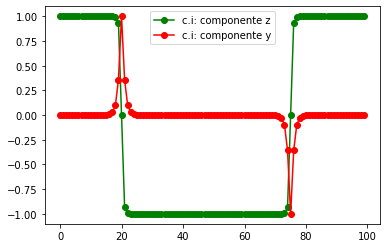

In [49]:
#Imprimo el vector de espines fisicos partiendo del S convergido final

x = np.zeros(Nsitios)
y = np.zeros(Nsitios)
z = np.zeros(Nsitios)

for i in range(Nsitios):
    x[i]=S[3*i+0]
    y[i]=S[3*i+1]
    z[i]=S[3*i+2]

plt.plot(n,z, 'o-g',label='c.i: componente z')
plt.plot(n,y, 'o-r',label='c.i: componente y')

plt.legend()
plt.savefig('final plot.png',dpi=300)